In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/gdriveupmebot/archive.zip" -d "/tmp/data"

In [3]:
!pip install split_folders

In [48]:
import os
import numpy as np
from PIL import Image
from matplotlib.image import imread
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import splitfolders as sf

# Preprocessing

In [5]:
head_dir="/tmp/data"

In [6]:
print("Number of pictures")
for dir in os.listdir(head_dir):
  print(dir+": "+ str(len(os.listdir(head_dir+"/"+dir))))


Number of pictures
non-COVID: 1229
COVID: 1252


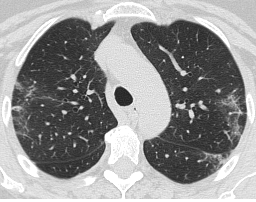

In [7]:
Image.open("/tmp/data/COVID/Covid (1).png")

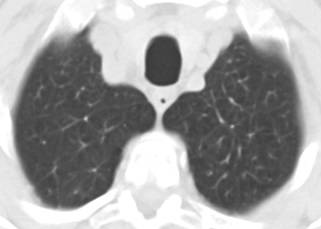

In [8]:
Image.open("/tmp/data/non-COVID/Non-Covid (1).png")

Shape of pics

In [9]:
sample=Image.open("/tmp/data/non-COVID/Non-Covid (1).png")
sample.size

(321, 229)

In [10]:
sample.mode

'RGBA'

In [11]:
width=[]
height=[]

for dir in os.listdir(head_dir+"/COVID"):
  width_temp,height_temp=Image.open(head_dir+"/COVID/"+dir).size
  width.append(width_temp)
  height.append(height_temp)

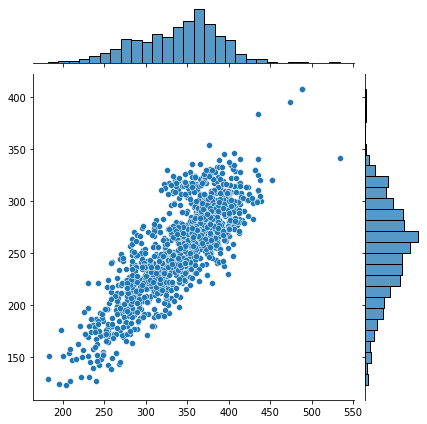

In [12]:
sns.jointplot(x=width,y=height)

In [13]:
print(sum(width)/len(width))
print(sum(height)/len(height))

338.2667731629393
252.7803514376997


In [14]:
width=[]
height=[]

for dir in os.listdir(head_dir+"/non-COVID"):
  width_temp,height_temp=Image.open(head_dir+"/non-COVID/"+dir).size
  width.append(width_temp)
  height.append(height_temp)

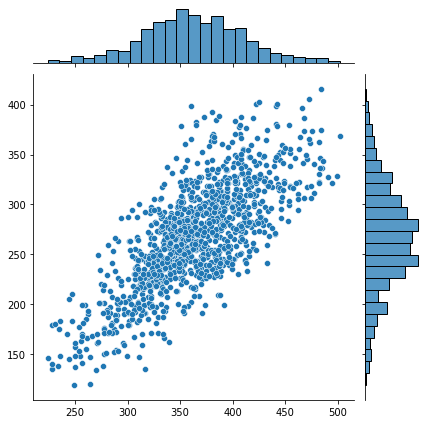

In [15]:
sns.jointplot(x=width,y=height)

In [16]:
print(sum(width)/len(width))
print(sum(height)/len(height))

362.6859235150529
267.2262001627339


**Train test split**

In [17]:
sf.ratio(head_dir, "/tmp/new data")

Copying files: 2481 files [00:00, 3178.08 files/s]


In [18]:
head_dir="/tmp/new data"

In [19]:
train=head_dir+"/train"
test=head_dir+"/test"
val=head_dir+"/val"

In [20]:
generate= ImageDataGenerator(vertical_flip=True,
                             rotation_range=10,
                             width_shift_range=.1,
                             height_shift_range=.1,
                             rescale=1/255)

In [21]:
train=generate.flow_from_directory(train,target_size=(350,260),color_mode="rgba",shuffle=True)
test=generate.flow_from_directory(test,target_size=(350,260),color_mode="rgba",shuffle=False)
val=generate.flow_from_directory(val,target_size=(350,260),color_mode="rgba",shuffle=False)

Found 1984 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Found 247 images belonging to 2 classes.


In [30]:
train.class_indices

{'COVID': 0, 'non-COVID': 1}

# Model

In [22]:
es=EarlyStopping(patience=2)

In [37]:
model = Sequential()

model.add(Conv2D(128, (7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train, validation_data=val, callbacks=[es], epochs=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/15
62/62 [==============================] - 97s 1s/step - loss: 2.2380 - accuracy: 0.6976 - val_loss: 47.5920 - val_accuracy: 0.5061
Epoch 2/15
62/62 [==============================] - 71s 1s/step - loss: 1.0293 - accuracy: 0.7787 - val_loss: 44.4160 - val_accuracy: 0.5061
Epoch 3/15
62/62 [==============================] - 72s 1s/step - loss: 0.6727 - accuracy: 0.7853 - val_loss: 19.6624 - val_accuracy: 0.5061
Epoch 4/15
62/62 [==============================] - 72s 1s/step - loss: 0.5167 - accuracy: 0.8261 - val_loss: 8.1183 - val_accuracy: 0.4980
Epoch 5/15
62/62 [==============================] - 71s 1s/step - loss: 0.6147 - accuracy: 0.7949 - val_loss: 2.1436 - val_accuracy: 0.6032
Epoch 6/15
62/62 [==============================] - 71s 1s/step - loss: 0.5388 - accuracy: 0.8120 - val_loss: 0.8356 - val_accuracy: 0.7530
Epoch 7/15
62/62 [==============================] - 71s 1s/step - loss: 0.4613 - accuracy: 0.8372 - val_loss: 0.6285 - val_accuracy: 0.7854
Epoch 8/15
62/62 

# Results

In [38]:
import pandas
history=pandas.DataFrame(model.history.history)

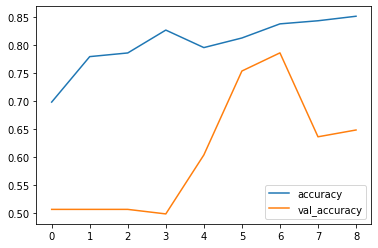

In [39]:
history[["accuracy","val_accuracy"]].plot()

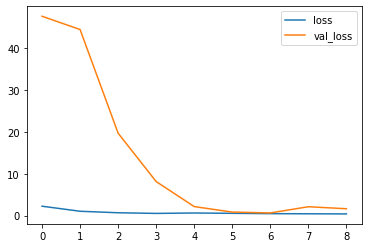

In [40]:
history[["loss","val_loss"]].plot()

In [46]:
prediction=np.argmax(model.predict(test), axis=-1)

In [50]:
print(classification_report(prediction, test.classes))

              precision    recall  f1-score   support

           0       0.44      0.62      0.51        89
           1       0.73      0.56      0.63       161

    accuracy                           0.58       250
   macro avg       0.58      0.59      0.57       250
weighted avg       0.62      0.58      0.59       250



In [51]:
confusion_matrix(prediction, test.classes)

array([[55, 34],
       [71, 90]])